In [49]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
data_csv = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')

/tmp/ipykernel_18296/4019203779.py:6: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data_csv = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')


In [50]:
# Liste des colonnes à conserver
variables_pertinentes = [
    'created_datetime','code', 'product_name', 'brands', 'categories', 'ingredients_text', 'additives_tags', 'nutrition_grade_fr',
    'energy_100g', 'proteins_100g', 'carbohydrates_100g', 'sugars_100g', 'fat_100g', 'saturated-fat_100g',
    'alcohol_100g', 'countries_fr','potassium_100g','calcium_100g','vitamin-a_100g','vitamin-c_100g','vitamin-d_100g','fiber_100g','cholesterol_100g','image_url'
]

start = time.time()
data = data_csv.drop([col for col in data_csv.columns if col not in variables_pertinentes], axis=1)
end = time.time()
print(f"Temps d'exécution de la méthode drop() : {end - start:.4f} secondes")

Temps d'exécution de la méthode drop() : 0.0392 secondes


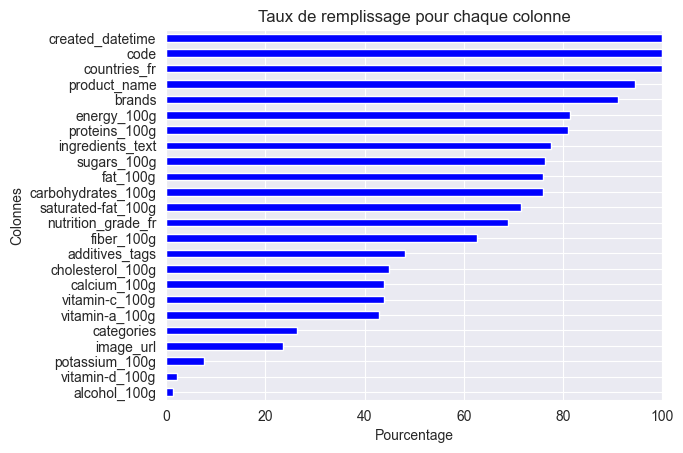

In [51]:
#taux de remplissage des variables

missing_values = 100*(data[variables_pertinentes].notnull().mean())
missing_values = missing_values.sort_values(ascending=True)
missing_values.plot(kind='barh',title='Taux de remplissage pour chaque colonne', color='blue', xlim=[0,100])
plt.xlabel('Pourcentage')
plt.ylabel('Colonnes')
plt.show()

In [52]:
#La variables energy est obligatoire ainsi que product_name
empty_mandatory_variables = data[
    (data['product_name'].isnull())
]
print(f'Les individus un nom de produit vide sont aux nombre de {len(empty_mandatory_variables)}')
data.drop(empty_mandatory_variables.index, inplace=True)

Les individus un nom de produit vide sont aux nombre de 17762


<function show at 0x7fcecd50df30>


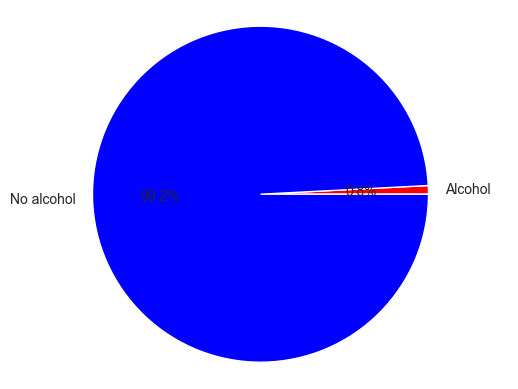

In [53]:
#Les produits contenant de l'alcool sont à bannir
#imputation par 0 des valeurs Null
data.loc[data['alcohol_100g'].isnull(), 'alcohol_100g'] = 0
data_alcohol = data[data['alcohol_100g'] > 0]
data_no_alcohol = data[data['alcohol_100g'] == 0]
percent_alcohol = len(data_alcohol) / len(data)
percent_no_alcohol = len(data_no_alcohol) / len(data)
labels = ['Alcohol', 'No alcohol']
sizes = [percent_alcohol, percent_no_alcohol]
colors = ['red', 'blue']
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
ax.axis('equal')
print(plt.show)
indices_to_drop = data[data['alcohol_100g'] > 0].index
data = data.drop(indices_to_drop)

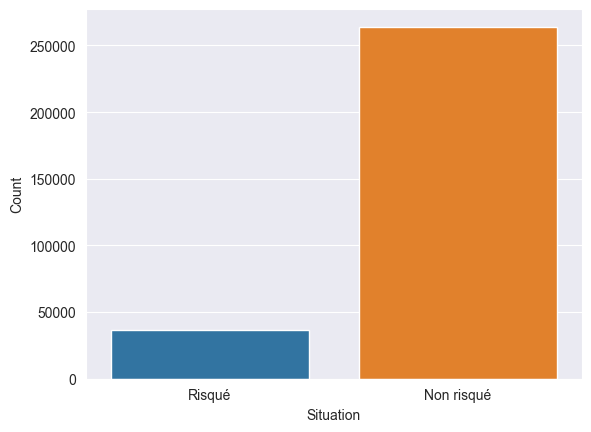

In [54]:
#les additifs
data.loc[data['additives_tags'].isnull(), 'additives_tags'] = ''
risky_additives = ['E250', 'E450', 'E202', 'E407', 'E252', 'E621', 'E224', 'E211', 'E482', 'E249', 'E212', 'E343',
                   'E1102', 'E511', 'E155']
risky_additives_regex = '|'.join(risky_additives)  # join the elements of the list with `|`
data['additives_tags_clean'] = data['additives_tags'].str.replace('en:', '')

# print(data.loc[40:55, 'additives_tags_clean'])
data['risky'] = 'non'
risky = data[data['additives_tags_clean'].str.contains(risky_additives_regex, case=False)]
data.loc[risky.index, 'risky'] = 'oui'

risky_count = len(data[data['risky'] == 'oui'])
non_risky_count = len(data[data['risky'] == 'non'])
# Créer un dataframe avec les données à afficher dans le graphique
risky_frame = pd.DataFrame({'Situation': ['Risqué', 'Non risqué'], 'Count': [risky_count, non_risky_count]})
sns.barplot(x='Situation', y='Count', data=risky_frame)

#retirer les aliments risqué
data.drop(data[data['risky'] == 'oui'].index, inplace=True)


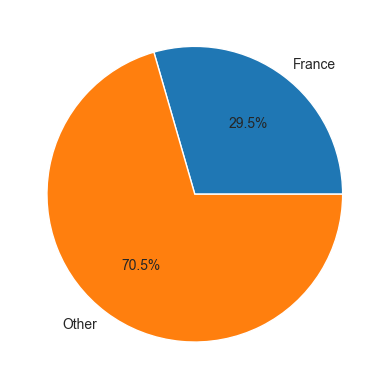

In [55]:
france_data = data[data['countries_fr'].str.contains('France', na=False)]
other_data = data[~data['countries_fr'].str.contains('France', na=False)]
france_percentage = len(france_data) / len(data) * 100
other_percentage = len(other_data) / len(data) * 100
plt.pie([france_percentage, other_percentage], labels=['France', 'Other'], autopct='%1.1f%%')
plt.show()



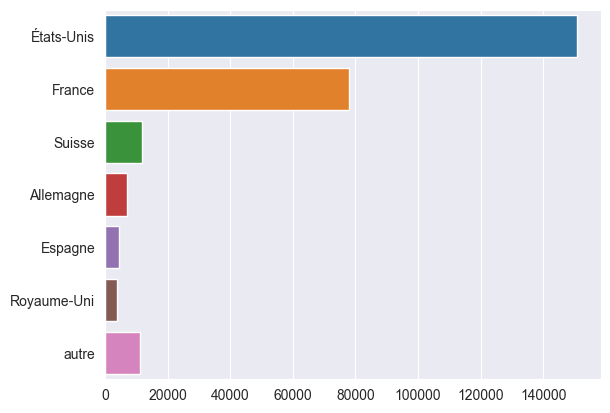

In [56]:
#répartition des produits par pays
pays = [
    "Afrique du Sud","Albanie","Algérie","Allemagne","Andorre","Angola","Arabie saoudite","Argentine","Arménie","Australie","Autriche","Azerbaïdjan",
    "Bahreïn","Bangladesh","Belgique","Belize","Bénin","Bhoutan","Biélorussie","Bolivie","Bosnie-Herzégovine","Botswana","Brésil","Brunei","Bulgarie","Burkina Faso","Burundi",
    "Cambodge","Cameroun","Canada","Cap-Vert","Chili","Chine","Chypre","Colombie","Comores","Congo","Corée du Nord","Corée du Sud","Costa Rica","Côte d'Ivoire","Croatie","Cuba",
    "Danemark","Djibouti","Dominique",
    "Égypte","Émirats arabes unis","Équateur","Érythrée","Espagne","Estonie","États-Unis","Éthiopie",
    "Fidji","Finlande","France",
    "Gabon","Gambie","Géorgie","Ghana","Grèce","Grenade","Guatemala","Guinée","Guinée-Bissau","Guinée équatoriale","Guyana",
    "Haïti","Honduras","Hong Kong","Hongrie",
    "Îles Marshall","Inde","Indonésie","Irak","Iran","Irlande","Islande","Israël","Italie",
    "Jamaïque","Japon","Jordanie",
    "Kazakhstan","Kenya","Kirghizistan","Kiribati","Koweït",
    "Laos","Lesotho","Lettonie","Liban","Liberia","Libye","Liechten","Liban","Lituanie","Luxembourg",
    "Malaisie","Malawi", "Mali", "Malte", "Maroc", "Maurice", "Mauritanie", "Mexique", "Moldavie", "Monaco","Mongolie", "Monténégro",
    "Nigeria", "Norvège", "Nouvelle-Calédonie", "Nouvelle-Zélande",
    "Oman",
    "Pays-Bas", "Pérou", "Philippines", "Pologne", "Portugal",
    "Qatar",
    "Roumanie", "Royaume-Uni", "République centrafricaine", "République dominicaine", "République tchèque",
    "Salvador", "Serbie", "Singapour", "Slovaquie", "Slovénie", "Suède",    "Suisse",
    "Taiwan", "Tanzanie", "Thaïlande", "Togo", "Tunisie", "Turquie",
    "Ukraine",
    "Venezuela", "Viêt Nam",
    "Yémen",
    "Zambie", "Zimbabwe"
]

data['countries_split'] = data['countries_fr'].str.split(',')
countries_series = data['countries_split'].explode().value_counts()
filtered_series = countries_series[countries_series.index.isin(pays)]

seuil = 3000
pays = filtered_series.loc[filtered_series >= seuil]
autre = pd.Series([filtered_series.loc[filtered_series < seuil].sum()], index=['autre'])
reordered_series =  pd.concat([pays, autre])

sns.barplot(x=reordered_series.values, y=reordered_series.index)
plt.show()

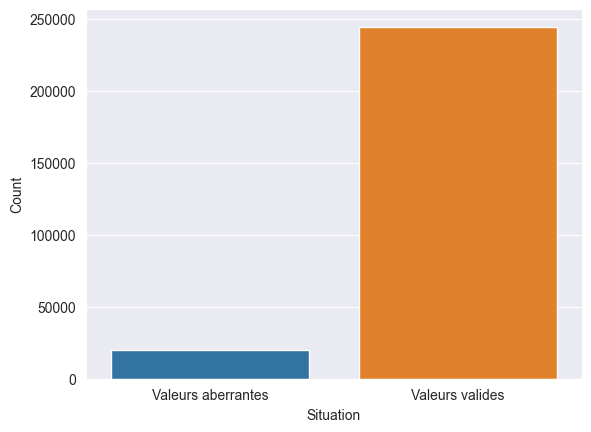

In [57]:
#enlever les valeurs non numériques aberrantes
list = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g']
for v in list:
    data[v] = pd.to_numeric(data[v], errors='coerce')
    data.loc[data[v].isnull(), v] = 0
    data.loc[data[v] > 100, v] = 100

#les valeurs énergétiques sont aberrantes si les graisses saturées > aux graisses, si les sucres > carbohydrates et si la somme des carbohydrates, protéines et lipides dépassent 100g
aberrants = data[(data['saturated-fat_100g'] > data['fat_100g']) |
                 (data['sugars_100g'] > data['carbohydrates_100g']) |
                 (data['carbohydrates_100g'] + data['proteins_100g'] + data['fat_100g'] > 100)]

aberrants_count = len(aberrants)

aberrants_frame = pd.DataFrame(
    {'Situation': ['Valeurs aberrantes', 'Valeurs valides'], 'Count': [aberrants_count, len(data) - aberrants_count]})
sns.barplot(x='Situation', y='Count', data=aberrants_frame)
#suppression des valeurs aberrantes
data.drop(aberrants.index, inplace=True)

In [58]:
#Valeur aberrantes énergétiques: création d'une colonne supplémentaire avec le bon calcul énergétique
kcal_prot = 4
kcal_glucide = 4
kcal_lipide = 9
data['kcal'] = (data['proteins_100g'] * kcal_prot + data['carbohydrates_100g'] * kcal_glucide + data['fat_100g'] * kcal_lipide)
# #Suppression des valeurs énergétiques <= 0 ou > 900
mask = ((data['kcal'] <= 0) | (data['kcal'] > 900 ))
data.drop(data[mask].index, inplace=True)

Le nombre de lignes < 100 calories 141278
Le nombre de lignes > 900 calories 0


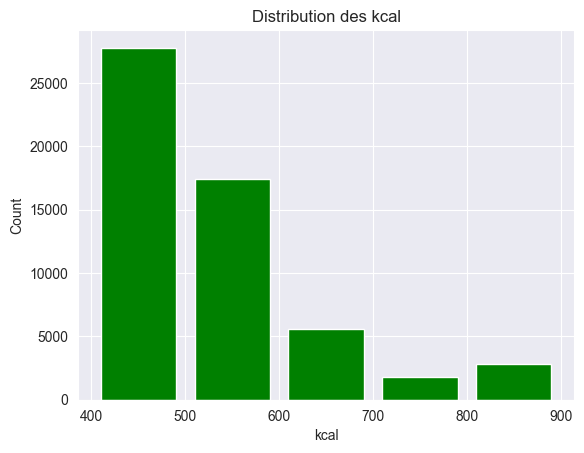

In [59]:
#les kcal < 100 ou > 900 sont aberrantes
print(f'Le nombre de lignes < 100 calories {(data["kcal"] < 400).sum()}')
print(f'Le nombre de lignes > 900 calories {(data["kcal"] > 900).sum()}')
mask = (data['kcal'] < 400) | (data['kcal'] > 900)
data.drop(data[mask].index, inplace=True)
# (Distribution du nombre de produits par tranche d'énergie)
bins = [400, 500, 600, 700, 800, 900]

# # Plot the histogram
data['kcal'].hist(bins=bins, rwidth=0.8, color='g')

# # Add axis labels and plot title
plt.xlabel("kcal")
plt.ylabel("Count")
plt.title("Distribution des kcal")
plt.show()

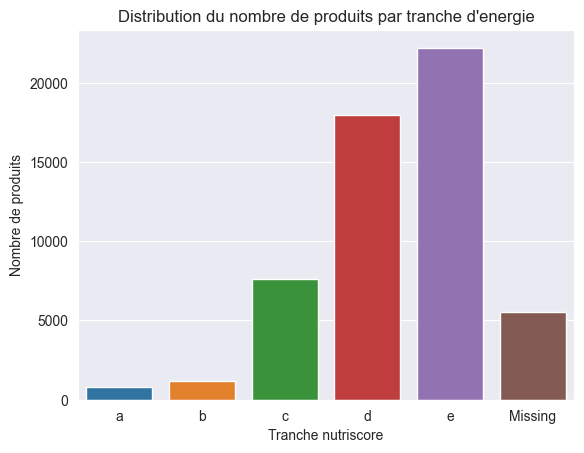

e          22212
d          17947
c           7643
Missing     5551
b           1199
a            779
Name: nutrition_grade_fr, dtype: int64


In [60]:
#distribution produits par nutriscore
# Countplot with the order specified
# Fill the missing values with 'Missing'
data['nutrition_grade_fr'] = data['nutrition_grade_fr'].fillna('Missing')
order = ['a','b','c','d','e','Missing']
sns.countplot(x='nutrition_grade_fr', data=data, order=order)

# Set the plot's title and axis labels
plt.title("Distribution du nombre de produits par tranche d'energie")
plt.xlabel("Tranche nutriscore")
plt.ylabel("Nombre de produits")
# Display the plot
plt.show()
# Print the counts of each value
print(data['nutrition_grade_fr'].value_counts())

In [62]:
#doublons
def keep_recent(df):
    last_date = df['created_datetime'].max()
    return df[df['created_datetime'] == last_date].index[0]

data = data.loc[data.groupby('code', group_keys=False).apply(keep_recent)]
data.loc[data['code'].duplicated(keep=False),:]
len(data)

55310